## Логістична регресія з регуляризацією

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [2]:
def loaddata(file, delimeter):
    data = np.loadtxt(file, delimiter=delimeter)
    print('Dimensions: ', data.shape)
    print(data[1:6,:])
    return(data)

In [3]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    # Get indexes for class 0 and class 1
    neg = data[:, 2] == 0
    pos = data[:, 2] == 1
    
    # If no specific axes object has been passed, get the current axes.
    if axes == None:
        axes = plt.gca()
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='x', c='green', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='darkorange', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
def predict(Theta, X, threshold=0.5):
    p = sigmoid(np.dot(X, Theta)) >= threshold
    return(p.astype('int'))

In [6]:
data2 = loaddata('data2.txt', ',')

Dimensions:  (118, 3)
[[-0.092742  0.68494   1.      ]
 [-0.21371   0.69225   1.      ]
 [-0.375     0.50219   1.      ]
 [-0.51325   0.46564   1.      ]
 [-0.52477   0.2098    1.      ]]


In [7]:
y = np.c_[data2[:,2]]
X_raw = data2[:,0:2]

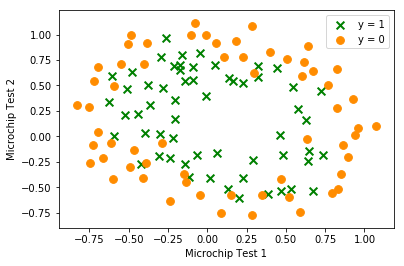

In [8]:
plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0')

In [9]:
# Note that this function inserts a column with 'ones' in the design matrix for the intercept.
poly = PolynomialFeatures(6)
X = poly.fit_transform(data2[:,0:2])
X.shape

(118, 28)

Функція варотості логістичної регресії з регуляризацією
$$ J(\Theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\Theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
Функція вартості у векторизованому вигляді
$$ J(\Theta) = \frac{1}{m}\big(-y^T\,log\,(\sigma(X\Theta))-(1-y)^T(\,log\,(1-\sigma(X\Theta))\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$

In [ ]:
def costFunctionReg(Theta, X, y, lmbd):
    m = y.size
    
    a = sigmoid(np.dot(X, Theta))
    
    J = (1/m)*(np.dot(-y.T, np.log(a)) - np.dot((1 - y).T, np.log(1 - a))) + (lmbd/(2*m))*np.sum(np.square(Theta[1:])) 
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

Градієнт функції з регуляризацією втрат у векторизованому вигляді
$$ \nabla J(\Theta) = \frac{1}{m} X^T(\sigma(X\Theta)-y) + \frac{\lambda}{m}\theta_{j}$$

In [ ]:
def gradientReg(Theta, X, y, lmbd):
    m = y.size
    
    a = sigmoid(np.dot(X, Theta.reshape(-1,1)))
      
    grad = (1/m)*X.T.dot(a-y) + (lmbd/m)*np.r_[[[0]], Theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

In [ ]:
init_Theta = np.zeros(X.shape[1]).reshape(-1,1)

In [ ]:
costFunctionReg(init_Theta, X, y, 1)

In [ ]:
fig, axes = plt.subplots(1,3, sharey = True, figsize=(17,5))

# Decision boundaries
# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias

for i, lmbd in enumerate([0, 1, 100]):
    # Optimize costFunctionReg
    res = minimize(costFunctionReg, init_Theta, args=(X, y, lmbd), method=None, jac=gradientReg, options={'maxiter':3000})
    
    # Accuracy
    accuracy = 100*sum(predict(res.x, X) == y.ravel())/y.size    

    # Scatter plot of X,y
    plotData(data2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', axes.flatten()[i])
    
    # Plot decisionboundary
    x1_min, x1_max = X_raw[:,0].min(), X_raw[:,0].max(),
    x2_min, x2_max = X_raw[:,1].min(), X_raw[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    a = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res.x))
    a = a.reshape(xx1.shape)
    axes.flatten()[i].contour(xx1, xx2, a, [0.5], linewidths=1, colors='blue');       
    axes.flatten()[i].set_title('Train accuracy {}% with $\lambda$ = {}'.format(np.round(accuracy, decimals=2), lmbd))
